In [1]:
import os
import os.path 
import cv2
import tkinter as tk
import tkinter.filedialog as fd
from PIL import Image
from skimage import transform, img_as_int, exposure, img_as_ubyte
import skimage.io as io
import skimage as si
import tkinter.messagebox as mb
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage, spatial
from cmath import inf
import sys
import numpy as np
from scipy.optimize import curve_fit
import json
from Bio import SeqIO
from skimage.filters import gaussian
import pandas as pd
from skimage.feature import peak_local_max
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from math import floor, ceil, exp
from skimage.registration import phase_cross_correlation
from scipy import ndimage as ndi
from scipy.io import savemat
import Polywarp


root = tk.Tk()
root.attributes("-topmost", True)
root.withdraw()

''

In [9]:
def get_pos(record):
    
    des = record.description
    tile_num = int(des.split(' ')[0].split(':')[4])
    x_pos = int(des.split(' ')[0].split(':')[5])
    y_pos = int(des.split(' ')[0].split(':')[6])
    return tile_num, x_pos, y_pos


def generate_img(x, y, x_min, y_min, x_max, y_max, r, blurred, sigma):
    # x_min = min(x)
    # x_max = max(x)
    # y_min = min(y)
    # y_max = max(y)
    x_range = x_max - x_min
    y_range = y_max - y_min
    # x_range = 27994
    # y_range = 27174
    img = np.zeros(shape=(x_range, y_range))
    for i in range(0, len(x)):
        img[min(x_range-1,max(0,int(x[i]-r))):min(x_range-1,max(0,int(x[i]+r+1))),min(y_range-1,max(0,int(y[i]-r))):min(y_range-1,max(0,int(y[i]+r+1)))] = 200

    if blurred:
        img = gaussian(img, sigma=sigma)
    im = Image.fromarray(img)
    new_im = im.convert("L")
#     new_im.save(op_path)
    return new_im


def generate_with_marker(x, y, marker_x, marker_y, op_path, csv_path):
    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    x_range = x_max - x_min + 1
    y_range = y_max - y_min + 1
    img = np.zeros(shape=(x_range, y_range, 3))
    marker_dic = {'index': range(0, len(marker_x)), 'x': [], 'y': []}
    for i in range(0, len(x)):
        for j in range(0, 5):
            for k in range(0, 5):
                img[max(0, x[i] - x_min - j),
                    max(0, y[i] - y_min - k), 0:3] = 255
                img[min(x_range - 1, x[i] - x_min + j),
                    max(0, y[i] - y_min - k), 0:3] = 255
                img[min(x_range - 1, x[i] - x_min + j),
                    min(y_range - 1, y[i] - y_min + k), 0:3] = 255
                img[max(0, x[i] - x_min - j),
                    min(y_range - 1, y[i] - y_min + k), 0:3] = 255
    for i in range(0, len(marker_x)):
        marker_dic['x'].append(marker_x[i] - x_min)
        marker_dic['y'].append(marker_y[i] - y_min)
        for j in range(0, 5):
            for k in range(0, 5):
                img[max(0, marker_x[i] - x_min - j),
                    max(0, marker_y[i] - y_min - k), 0] = 255
                img[max(0, marker_x[i] - x_min - j),
                    max(0, marker_y[i] - y_min - k), 1:3] = 0
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    max(0, marker_y[i] - y_min - k), 0] = 255
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    max(0, marker_y[i] - y_min - k), 1:3] = 0
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    min(y_range - 1, marker_y[i] - y_min + k), 0] = 255
                img[min(x_range - 1, marker_x[i] - x_min + j),
                    min(y_range - 1, marker_y[i] - y_min + k), 1:3] = 0
                img[max(0, marker_x[i] - x_min - j),
                    min(y_range - 1, marker_y[i] - y_min + k), 0] = 255
                img[max(0, marker_x[i] - x_min - j),
                    min(y_range - 1, marker_y[i] - y_min + k), 1:3] = 0
    blurred_img = gaussian(img, sigma=3, multichannel=True)
    im = Image.fromarray(blurred_img.astype(np.uint8))
    new_im = im.convert("P")
    new_im.save(op_path)
    df = pd.DataFrame(marker_dic)
    df.to_csv(csv_path, index=True, header=True)


def get_coordinates(fastq_path):
    x_coordinate_01 = []
    y_coordinate_01 = []
    x_coordinate_02 = []
    y_coordinate_02 = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == 1101:
                x_coordinate_01.append(x_pos)
                y_coordinate_01.append(y_pos)
            elif tile_num == 1102:
                x_coordinate_02.append(x_pos)
                y_coordinate_02.append(y_pos)
#     print('Coordinates are found.')
    return x_coordinate_01, y_coordinate_01, x_coordinate_02, y_coordinate_02


def get_xy_coordinates(fastq_path, with_seq):
    x_coordinate_01 = []
    y_coordinate_01 = []
    x_coordinate_02 = []
    y_coordinate_02 = []
    x_seq_coordinate_01 = []
    y_seq_coordinate_01 = []
    x_seq_coordinate_02 = []
    y_seq_coordinate_02 = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == 1101:
                if with_seq != seq:
                    x_coordinate_01.append(x_pos)
                    y_coordinate_01.append(y_pos)
                else:
                    x_seq_coordinate_01.append(x_pos)
                    y_seq_coordinate_01.append(y_pos)
            elif tile_num == 1102:
                if with_seq != seq:
                    x_coordinate_02.append(x_pos)
                    y_coordinate_02.append(y_pos)
                else:
                    x_seq_coordinate_02.append(x_pos)
                    y_seq_coordinate_02.append(y_pos)
#     print('Coordinates are found.')
    return x_coordinate_01, y_coordinate_01, \
        x_coordinate_02, y_coordinate_02, \
        x_seq_coordinate_01, y_seq_coordinate_01, \
        x_seq_coordinate_02, y_seq_coordinate_02


def get_seq_coordinates(fastq_path, tile):
    x_coordinate = []
    y_coordinate = []
    sequences = []
    for record in SeqIO.parse(fastq_path, "fastq"):
        if record is not None:
            tile_num, x_pos, y_pos = get_pos(record)
            seq = str(record.seq)
            if tile_num == tile:
                x_coordinate.append(x_pos/10)
                y_coordinate.append(y_pos/10)
                sequences.append(seq)
#     print('Coordinates are found.')
    return x_coordinate, y_coordinate, sequences

def find_max (x,y, arr):
    
#     print(np.shape(arr))
#     print((arr))
    max_elem = -1
    for i in range(x-5, x+6):
        for j in range(y-5, y+6):
            if arr[j][i] > max_elem:
                max_elem =  arr[j][i]

    list_index_max =[(i,j) for i in range(x-5, x+6)  for j in range(y-5, y+6) if arr[j][i]  == max_elem]
    line, column = list_index_max[0]
    return(line, column)
#https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/  
# function to display the coordinates of  of the points clicked on the image


def click_event_FRET(event, x, y, flags, params):
    global counter
    global FRET_coord
    if event == cv2.EVENT_LBUTTONDOWN:   # checking for left mouse clicks   
        x_max,y_max = find_max(x,y,image_array_F)
#         print(x_max, y_max)
        FRET_coord.append(x_max) 
        FRET_coord.append(y_max)
        cv2.circle(better_contrast_img, (x_max, y_max), 4, (0, 0, 127), 2)
        counter+=1    
    if event==cv2.EVENT_RBUTTONDOWN:
        counter = 0
        green_coord.clear()
        red_coord.clear()
        
def click_event_seq(event, x, y, flags, params):
    global counter
    global seq_coord
    if event == cv2.EVENT_LBUTTONDOWN:   # checking for left mouse clicks   
        x_max,y_max = find_max(x,y,image_array_seq_t)
#         print(x_max, y_max)
        seq_coord.append(x_max) 
        seq_coord.append(y_max)
        cv2.circle(better_contrast_img_2, (x_max, y_max), 4, (0, 0, 127), 2)
        counter+=1   
    if event==cv2.EVENT_RBUTTONDOWN:
        counter = 0
        green_coord.clear()
        red_coord.clear()


def scaling_seq (x, y):
    #x = int(1700+(330-x_border)/2  + (x - 27246.18)/0.34 ) ### tile 2
    #y = int(1571+(170-y_border)/2 - (y + 1149.66)/0.34)
    x = int(2329+(330-x_border)/2 + (x - 28522.9)/0.34)  ### tile 1 
    y = int(2042+(170-y_border)/2 - (y + 1313.3)/0.34)
    
    
    return (x,y)
    

def blob_detection(img, min_sigma, max_sigma, threshold, method=0):
    """This function is mostly used for detecting the beads in any image.

    Args:
        img_path (string): The absolute path of the input image.
        min_sigma (int): The minimum sigma, lower it is, smaller the blob will be detected.
        max_sigma (int): The maximum sigma, higher it is, bigger the blob will be detected.
        threshold (float): Higher it is, higher the intensities of blobs.
        method (int, optional): 0 for Difference of Gaussian (DoG) and 1 for Determinant of Hessian (DoH). 
        They should be applied with different combination of parameters. DoG is more suitable for fret movies,
        while DoH is more suitable for sequencing images. Defaults to 0.

    Returns:
        centers: A numpy array containing the coordinates of all the centers.
    """
    #img = io.imread(img_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    if method == 0:
        blob = blob_dog(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    else:
        blob = blob_doh(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    i = 0
    r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, r = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(np.flip(centers[i]), [x - r, y - r]))
            x1, y1 = centers[i]
            c = plt.Circle([x1, y1], 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
            
            i += 1
    ax.set_axis_off()
    plt.show()
    return np.array(centers)

def count_nearest_pts(src, dst, radius):
    """Counting the number of nearest neighbors for each given point.

    Args:
        src (numpy array): (N, 2) shape array. Build the kd tree based on this.
        dst (numpy array): (N, 2) shape array. For each point in this array, find the nearest neighbors in src array.
        radius (int): The maximum searching radius.

    Returns:
        res, idx: res is the distance for the point and its neighbor, 'inf' means no neighbor in given search radius. 
        idx is the index for the neighbor in src array.
    """
    tree = spatial.KDTree(src)
    res, idx = tree.query(dst, k=1, distance_upper_bound=radius)
    for i in range(0, len(idx)):
        idx_t = np.argwhere(idx == idx[i])
        if len(idx_t) > 1:
            res_t = [res[j] for j in idx_t]
            if res[i] > min(res_t): res[i] = inf
    return res, idx

class App(tk.Tk):
    
    def __init__(self):
        super().__init__()
        btn_file = tk.Button(self, text="Choose file",
                             command=self.choose_file)
        btn_dir = tk.Button(self, text="Choose folder",
                             command=self.choose_directory)
        btn_file.pack(padx=60, pady=10)
        btn_dir.pack(padx=60, pady=10)
        

    def choose_file(self):
        filetypes = (("All formats ", "*"),
                     ("Text file", "*.txt"),
                     ("Image", "*.jpg *.gif *.png *.bmp *.tif"))
        filename = fd.askopenfilename(title="Open file", initialdir="/",
                                      filetypes=filetypes)
        if filename:
            self.st = filename
            #print (filename)
           
            
    def choose_directory(self):
        directory = fd.askdirectory(title="Open folder", initialdir="/")
        if directory:
            self.dir = directory
#             print (directory)


In [3]:
#Instead of calculating the bead mapping we can load the transformation generated with channel_map


tr_G2R = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the forward transform file", initialdir = "C:/Users/Anton/Documents/Jupyter home/ExampleData/Test_folder/220717_FC_Nano_200nm_Multicolor/original")
tr_G2R.params = np.load(file_path)
tr_R2G = transform.PolynomialTransform()
file_path = fd.askopenfilename(title = "Choose the inverse transform file", initialdir = os.path.dirname(file_path))
tr_R2G.params = np.load(file_path)

path_smFRET = fd.askdirectory(title = "Choose the smFRET folder", initialdir = "D:/Experiments/MUSCLE DONUTS/")
# path_smFRET = fd.askdirectory(title = "Choose the smFRET movie", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/Cas9/green")


In [28]:
# x_border = int(input("Enter the x border"))
# y_border = int(input("Enter the y border"))
x_border = 400
y_border = 200

apriori_tr = transform.SimilarityTransform()
apriori_tr.params = np.array([[ 5.98278480e-01, -2.04811207e-03,  0],
 [ 2.04811207e-03,  5.98278480e-01,  0],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Centering the tranformation to the x_border and y_border
delta = 0.5*np.subtract([x_border,y_border],apriori_tr([512,256]))
dx, dy = delta[0]
apriori_tr.params[0,2] = dx
apriori_tr.params[1,2] = dy

apriori_tr_inv = transform.SimilarityTransform()
apriori_tr_inv.params = np.array([[ 1.67127284e+00,  5.72133913e-03,  0],
 [-5.72133913e-03,  1.67127284e+00,  0],
 [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Centering the tranformation to the x_border and y_border
delta = 0.5*np.subtract([512,256],apriori_tr_inv([x_border,y_border]))
dx, dy = delta[0]
apriori_tr_inv.params[0,2] = dx
apriori_tr_inv.params[1,2] = dy


In [5]:
# fastq_path = 'E:/MUSCLE data/0722.fastq'
fastq_path = fd.askopenfilename(title = "Choose the FASTQ file", initialdir = "D:/Experiments/MUSCLE DONUTS/")


x_coord, y_coord, sequence = get_seq_coordinates(fastq_path,  tile=1101)
# print(len(x_coordinate_01))
# print(len(x_coordinate_02))
# print(np.max(x_coordinate_01))
# print(np.min(x_coordinate_01))

# max_y  = max (y_coord)
# max_x = max (x_coord)
max_y  = max_x = 3000 # To ensure that the alignment is not affected by changes in max x and y


x_coord1 = np.subtract(max_y, y_coord)
y_coord = np.subtract(max_x, x_coord)

x_coord = x_coord1

# Correction for the shift between FASTQ and cluster images
x_coord = np.subtract(x_coord, 97.5)
y_coord = np.subtract(y_coord, 3)

max_x1 = ceil(max_y)
max_y = ceil(max_x)
max_x = max_x1
# max_x = ceil(max_x)
# max_y = ceil(max_y)

# generate_with_marker(x_coordinate_01, y_coordinate_01, x_coordinate_01m, y_coordinate_01m,
#   '/Users/qinhanhou/Desktop/DeindlLab/220722/SeqImg/1101_marked_sigma3.png',
#   '/Users/qinhanhou/Desktop/DeindlLab/220722/SeqImg/1101_marked_sigma3.csv')

library_seq =  'GGTCTCGTCCAATCTAT'

['Pos148', 'Pos149', 'Pos150', 'Pos151', 'Pos152', 'Pos153', 'Pos154', 'Pos155', 'Pos180', 'Pos181', 'Pos182', 'Pos183', 'Pos184', 'Pos185', 'Pos186', 'Pos187', 'Pos214', 'Pos215', 'Pos216', 'Pos217', 'Pos218', 'Pos219', 'Pos220', 'Pos221', 'Pos246', 'Pos247', 'Pos248', 'Pos249', 'Pos250', 'Pos251', 'Pos252', 'Pos253', 'Pos280', 'Pos281', 'Pos282', 'Pos283', 'Pos284', 'Pos285', 'Pos286', 'Pos287', 'Pos312', 'Pos313', 'Pos314', 'Pos315', 'Pos316', 'Pos317', 'Pos318', 'Pos319', 'Pos346', 'Pos347', 'Pos348', 'Pos349', 'Pos350', 'Pos351', 'Pos352', 'Pos353', 'Pos378', 'Pos379', 'Pos380', 'Pos381', 'Pos382', 'Pos383', 'Pos384', 'Pos385', 'Pos412', 'Pos413', 'Pos414', 'Pos415', 'Pos416', 'Pos417', 'Pos418', 'Pos419', 'Pos444', 'Pos445', 'Pos446', 'Pos447', 'Pos448', 'Pos449', 'Pos450', 'Pos451', 'Pos478', 'Pos479', 'Pos480', 'Pos481', 'Pos482', 'Pos483', 'Pos484', 'Pos485']


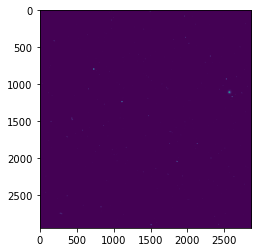

In [29]:

file_path = fd.askopenfilename(title = "Choose the position list", initialdir = "D:/Experiments/MUSCLE DONUTS/")
current_direct = fd.askdirectory(title = "Choose the output folder", initialdir = "D:/Experiments/MUSCLE DONUTS/")


pos_file = open(file_path)
data = json.load(pos_file)
POS = data['POSITIONS']

labels = [P['LABEL'] for P in POS]
posX = [P['DEVICES'][0]['X'] for P in POS]
posY = [P['DEVICES'][0]['Y'] for P in POS]


#X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos287']
#Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos287']

labels_res = []
posX_res = []
posY_res = []
for i,x in enumerate(labels):
    #x = int(1700+(330-x_border)/2 + (posX[i] - 27246.18)/0.34) #tile 2 19/07/2022
    #y = int(1571+(170-y_border)/2  - (posY[i] + 1149.66)/0.34)   
    x = int(2329+(330-x_border)/2 + (posX[i] - 28522.9)/0.34) # tile 1 19/07/2022
    y = int(2042+(170-y_border)/2 - (posY[i] + 1313.3)/0.34) 
    if (x > 0 ) and (y > 0):
        if (y+y_border<2866) and (x+x_border < 2944) :
            labels_res.append (labels[i])
            posX_res.append (posX[i])
            posY_res.append( posY[i])


print (labels_res)

#print(usable_green_beads)
#print(usable_red_beads)
fastq_image = generate_img(y_coord,x_coord, 0, 0, max_y, max_x, 1, True, 1)
fastq_image.save(os.path.join(current_direct, 'FASTQ_image.png'))


counter = 0  

file_path = fd.askopenfilename(title = "Choose the MIN projection image", initialdir = "D:/Experiments/MUSCLE DONUTS/")
seq = io.imread(file_path)#reading the sequence image
seq = seq.astype("ushort") 

file_path = fd.askopenfilename(title = "Choose the MAX projection image", initialdir = "D:/Experiments/MUSCLE DONUTS/")
seq_max = io.imread(file_path)#reading the sequence image
seq_max = seq_max.astype("ushort")
image_array_max = np.asarray(seq_max)
good_pos = []
matched_sequences = []
matched_centers_red = []
matched_centers_green = []

image_array_seq = np.asarray(seq) #array from sequence image
image_array_FQ = np.asarray(fastq_image) #array from fastq_image
beads_dir = fd.askdirectory(title = "Choose the beads folder", initialdir = "D:/Experiments/MUSCLE DONUTS/")
plt.figure()
plt.imshow(seq)


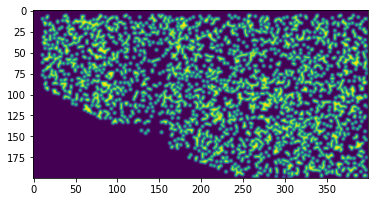

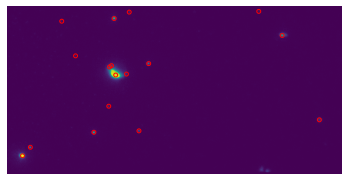

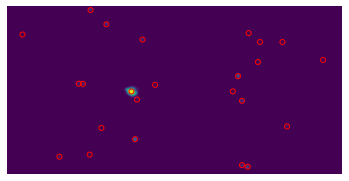

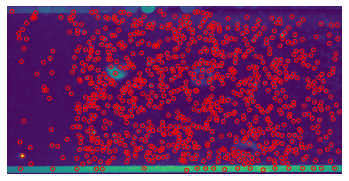

Matched clusters before polywarp:  470
Matched clusters after polywarp:  384
Out of  880  smFRET peaks and  1495  clusters
Percentage of marched smFRET peaks:  43.63636363636363
Percentage of marched clusters:  25.68561872909699


KeyboardInterrupt: 

In [72]:

for pos in labels_res :
#     for current_dir,dirs, files in os.walk(beads_dir) :
# #         for el in files:     
#             if el.split('.')[-2] == pos:
    path1 = os.path.join(beads_dir,pos+'.tiff')
    if os.path.exists(path1)&(not os.path.exists(os.path.join(path_smFRET, pos + "_traces.mat"))):
#         data['sequence'] = []
        pos_direct = os.path.join(current_direct, pos)
        os.makedirs(pos_direct, exist_ok=True)
        log_file = open(os.path.join(pos_direct, pos + "_log.txt"), 'w')
        log_file.write('Working on: '+ pos+'\n')
        FRET_coord = []
        seq_coord = []
        point = []
        counter = 0
        rb_rad = 10
        img_beads_F = io.imread(path1) #reading the stack of images
        if len(img_beads_F.shape) == 3:
            img_beads_F = np.mean(img_beads_F, axis = 0) #averaging by the stack
        img_beads_F = img_beads_F.astype("ushort") #turn from float format to ushort
        img_beads_F = img_beads_F [256:512, 0:512]
        img_beads_F = img_beads_F - si.restoration.rolling_ball(img_beads_F, radius=rb_rad)
        image_array_F = transform.warp(img_beads_F, apriori_tr_inv, output_shape = [y_border, x_border])
        image_array_F = img_as_ubyte(image_array_F)
        #img = io.imread(current_dir + '/' + el) #initial reading of original averaging image
        #img = cv2.imread(app.st)
#         plt.figure()
#         plt.imshow(img1)
#         plt.figure()
#         plt.imshow(seq)

        image_array_F = np.asarray(image_array_F) #array from FRET image
#         plt.figure()
#         plt.imshow(image_array_F)
        
        idx = [i for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 X_c = [posX_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
#                 Y_c = [posY_res[i] for i,x in enumerate(labels_res) if labels_res[i]==pos]
        X_c = [posX_res[i] for i in idx]
        Y_c = [posY_res[i] for i in idx]

        X_c, Y_c = scaling_seq(X_c[0], Y_c[0])
#         print (X_c, Y_c)
        point.append(X_c)
        point.append(Y_c)
        point = np.array(point)
        image_array_seq_t = image_array_seq[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_max_t = image_array_max[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        image_array_FQ_t = image_array_FQ[ Y_c:Y_c+y_border, X_c:X_c+x_border]
        idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+x_border) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+y_border)]
        x_FQ = [x_coord[i] for i in idx]
        y_FQ = [y_coord[i] for i in idx]
        seq_t = [sequence[i] for i in idx]
        if len(seq_t)<100:
            log_file.write('Not enough clusters (<100)\n')
            continue



#                 for i in range (len(sequence)):
#                     if (x_coord[i] >= X_c) and (x_coord[i] <= X_c+330): 
#                         if (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+170):
#                                 data['sequence'].append({
#                                                      'X': x_coord[i],
#                                                      'Y': y_coord[i],
#                                                      'sequence': sequence[i]
#                                                         })

        #print(image_array)
        v_min, v_max = np.percentile(image_array_F, (0, 99.8))
        if v_max == 0: v_max = np.max(image_array_F)
        better_contrast_image_array = exposure.rescale_intensity(image_array_F, in_range=(v_min, v_max))
        better_contrast_img = Image.fromarray(better_contrast_image_array)
        better_contrast_img.save(pos_direct + '/'+pos + '_contr.tif')
        better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
        #reading by cv2 to make possible circles in color
        #img_jpg = io.imread('C:/Users/panf/Documents/Muscle_intermediates/AVG_G10_1_1_MMStack_Pos0.ome.jpg')
        #img_array = img_as_int(img)
        # displaying the image
        # setting mouse handler for the image
        # and calling the click_event() function
        image_seq = Image.fromarray(image_array_seq_t)
        image_seq.save (pos_direct + '/'+ pos+'_seq.tif')

        image_fastq = Image.fromarray(image_array_FQ_t)
#         plt.figure()
#         plt.imshow(image_fastq)
        image_fastq.save (pos_direct + '/'+ pos+'_fastq.tif')

        v_min, v_max = np.percentile(image_array_seq_t, (0, 99.8))
        if v_max == 0: v_max = np.max(image_array_seq_t)
        better_contrast_image_array_2 = exposure.rescale_intensity(image_array_seq_t, in_range=(v_min, v_max))
        better_contrast_img_2 = Image.fromarray(better_contrast_image_array_2)
        better_contrast_img_2.save(pos_direct + '/'+''+ pos+'_contr_MIN_seq_stack.tif')
        better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif')     

#         plt.figure()
#         plt.imshow( Image.fromarray(image_array_seq_t))     
        
        # User clicks of beads with "q" for exit when done
        FRET_coord = []
        seq_coord = []
        cv2.namedWindow(pos) 
        cv2.namedWindow(pos+'_seq') 
        cv2.setMouseCallback(pos,  click_event_FRET)
        cv2.setMouseCallback(pos+'_seq',  click_event_seq)
        #cv2.setMouseCallback('image1',  click_event)
        while(1):
            cv2.imshow(pos,better_contrast_img)
            cv2.imshow(pos+'_seq',better_contrast_img_2)
            k = cv2.waitKey(1)&0xFF 
            #if cv2.waitKey(20) & 0xFF == 27: #press Esc to quit
            if k == ord('q'): # Press 'q' to finish
                break
            elif k == ord('r'): # Press 'r' to restart
                counter = 0
                cv2.destroyAllWindows()
                FRET_coord = []
                seq_coord = []
                cv2.namedWindow(pos) 
                cv2.namedWindow(pos+'_seq') 
                cv2.setMouseCallback(pos,  click_event_FRET)
                cv2.setMouseCallback(pos+'_seq',  click_event_seq)
                better_contrast_img_2 = cv2.imread(pos_direct + '/'+pos+ '_contr_MIN_seq_stack.tif')
                better_contrast_img = cv2.imread(pos_direct + '/'+pos + '_contr.tif')
        
        cv2.destroyAllWindows()
        
        # If the user selected at least three beads we proceed with analysis
        if len(seq_coord) > 2: 
            
            seq_coord = np.reshape(seq_coord,(int((counter+1)/2), 2))
            
            FRET_coord = np.reshape(FRET_coord,(int((counter+1)/2), 2))
            FRET_coord = apriori_tr_inv(FRET_coord)
            result = np.concatenate ((FRET_coord, seq_coord), axis = 0)
            np.save(pos_direct + '/' + pos+'_manual_coord', result)
            
            # Calculating the shift between the FASTQ and cluster images using cross-correlation
            shift = phase_cross_correlation(image_array_max_t,image_array_FQ_t)
            shift = shift[0]
            # Translation of the FASTQ sequences in the FOV to match the cluster image
            x_FQ = np.subtract(x_FQ,X_c-shift[1])
            y_FQ = np.subtract(y_FQ,Y_c-shift[0])
            max_image = Image.fromarray(image_array_max_t)
            max_image.save(os.path.join(pos_direct,pos+'_MAX_seq.png'))
            fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, y_border, x_border, 1, True, 1)
            fastq_image1.save(os.path.join(pos_direct,pos+'_FQ_aligned.png'))
            fig, ax = plt.subplots()
            ax.imshow(fastq_image1)
            plt.show()


            # Selecting the library sequences for further analysis
            idx = [i for i,x in enumerate(seq_t) if library_seq in x]
            x_FQ = [x_FQ[i] for i in idx]
            y_FQ = [y_FQ[i] for i in idx]
            seq_t = [seq_t[i] for i in idx]

            # Calculating the first rough transformation based on manually-selected beads
            rough_tr = transform.estimate_transform("similarity", src=FRET_coord, dst=seq_coord)
            np.save(os.path.join(pos_direct, pos + "_man_bead_tr"), rough_tr)
            # Refining the transformation based on automatically-selected beads
            movie_centers = blob_detection(
                np.asarray(img_beads_F),
                min_sigma=1,
                max_sigma=10,
                threshold=0.01
            )

            seq_centers = blob_detection(
                image_array_seq_t,
                min_sigma=1,
                max_sigma=10,
                threshold=0.00001,
            )
            
            res, idx = count_nearest_pts(rough_tr(movie_centers), seq_centers, 8)
            movie_centers1 = movie_centers[idx[np.where(res != inf)]]
            seq_centers1 = seq_centers[np.where(res != inf)]
            if seq_centers1.shape[0] >2:
                log_file.write("Detected " + str(seq_centers1.shape[0]) + " matched beads. Updating the manual transformation\n")                
                rough_tr1 = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
            else:
                log_file.write("""Not enough (<3) automatically detected and matched beads to update the initial
                               transformation estimate based on manually selected beads\n""")
                rough_tr1 = rough_tr

            np.save(os.path.join(pos_direct, pos + "_auto_bead_tr"), rough_tr1)
            # Reading the smFRET movie
            img_smFRET = io.imread(os.path.join(path_smFRET,pos+'.tiff'))

            # Averaging the first 10 frames to select peaks
            img_t = np.mean(img_smFRET[0:10,::], axis = 0)
            img_t = img_t.astype("ushort")
            rb_rad = 10
            #print(img1[10:20,10:20])
            #img = np.zeros([20,20])
            #img[10,5] = 1000
            red = img_t[256:,:]
            green = img_t[:256,:]
            red = red - si.restoration.rolling_ball(red, radius=rb_rad)
            green = green - si.restoration.rolling_ball(green, radius=rb_rad)
            green = transform.warp(green,tr_R2G)
            combined = red + green # Consider adding the red excitation channel, though there are some difficulties, e.g. beads and int scaling
            fig, ax = plt.subplots()
            ax.imshow(combined)
            blobs_log = blob_log(combined, max_sigma=10, num_sigma=10, threshold=1000)
            CM = []
            r = 3
            [h,w] = red.shape
            n_frames = img_smFRET.shape[0]

            for i, blob in enumerate(blobs_log):
                x, y, d = blob
                if x>r and x<(h-r) and y>r and y<(w-r):
                    temp = ndimage.measurements.center_of_mass(combined[int(x-r):int(x+r+1),int(y-r):int(y+r+1)])
                    CM.append(np.flip(np.add(temp, [x-r,y-r])))

                    c = plt.Circle(CM[-1], 3, color="red", linewidth=1, fill=False)
                    ax.add_patch(c)
            ax.set_axis_off()
            plt.savefig(os.path.join(pos_direct, pos + "_smFRET_peaks.tiff"))
            plt.show()
            
            
            smFRET_centers = np.array(CM)
            FQ_centers = np.concatenate((x_FQ, y_FQ)).reshape((-1, 2), order='F')
            res, idx = count_nearest_pts(rough_tr1(smFRET_centers), FQ_centers, 8)
            movie_centers1 = smFRET_centers[idx[np.where(res != inf)]]
            seq_centers1 = FQ_centers[np.where(res != inf)]

            # Calculating the polynomial tranformation between FRET peaks and clusters
            
#             if seq_centers1.shape[0]>=9:
#                 order = 2
#             if seq_centers1.shape[0]>=4:
#                 order = 1
#             else: continue
            if seq_centers1.shape[0]<4: 
                log_file.write('Not enough smFRET peaks (<4)')
                continue
            
            tr = transform.estimate_transform("similarity", src=movie_centers1, dst=seq_centers1)
            tr_inv = transform.estimate_transform("similarity", src=seq_centers1, dst=movie_centers1)
            np.save(os.path.join(pos_direct, pos + "_final_tr"), tr)
            np.save(os.path.join(pos_direct, pos + "_final_tr_inv"), tr_inv)
            log_file.write('Matched clusters before polywarp: ' + str(seq_centers1.shape[0])+'\n')
            print('Matched clusters before polywarp: ',seq_centers1.shape[0])
            
#             kx,ky = Polywarp.polywarp(seq_centers1[:,0],seq_centers1[:,1],movie_centers1[:,0],movie_centers1[:,1],degree=order)
# #             print(kx)
# #             print(ky)
#             tr = transform.PolynomialTransform()
#             #tr.estimate(src,dst,order = 2)

#             order1 = 2*order
#             pidx = 0
#             par = np.zeros([2,int((order1+1)*(order1+2)/2)])
#             for j in range(order1 + 1):
#                 for i in range(j + 1):
#                     if (j-i)<=order and i<=order:
#                         par[0, pidx] = kx[j - i,i]
#                         par[1, pidx] = ky[j - i,i]
#                     else:
#                         par[0, pidx] = 0
#                         par[1, pidx] = 0
#                     pidx += 1
#             tr.params = par        

#             kx,ky = Polywarp.polywarp(movie_centers1[:,0],movie_centers1[:,1],seq_centers1[:,0],seq_centers1[:,1],degree=order)
#             tr_inv = transform.PolynomialTransform()
#             #tr.estimate(src,dst,order = 2)

#             order1 = 2*order
#             pidx = 0
#             par = np.zeros([2,int((order1+1)*(order1+2)/2)])
#             for j in range(order1 + 1):
#                 for i in range(j + 1):
#                     if (j-i)<=order and i<=order:
#                         par[0, pidx] = kx[j - i,i]
#                         par[1, pidx] = ky[j - i,i]
#                     else:
#                         par[0, pidx] = 0
#                         par[1, pidx] = 0
#                     pidx += 1
#             tr_inv.params = par

            res, idx = count_nearest_pts(tr(smFRET_centers), FQ_centers, 4)
            centers_matched = smFRET_centers[idx[np.where(res != inf)]]
            idx_t = np.where(res != inf)
            seq_matched = [seq_t[i] for i in idx_t[0]]
            FQ_centers_matched = FQ_centers[idx_t]
            
            
            centers_red = centers_matched
            centers_green = tr_R2G(centers_matched)
            r = 3
            # Weed out positions that are too close to the edge
            idx_t = np.where((centers_red[:,0]>r) & (centers_red[:,0]<(w-r)) & (centers_red[:,1]>r) & (centers_red[:,1]<(h-r))  & 
                             (centers_green[:,0]>r) & (centers_green[:,0]<(w-r)) & (centers_green[:,1]>r) & (centers_green[:,1]<(h-r)))
            centers_red = centers_red [idx_t]
            centers_green = centers_green [idx_t]
            seq_matched = [seq_matched[i] for i in idx_t[0]]
            
            matched_sequences.append(seq_matched)
            matched_centers_red.append(centers_red)
            matched_centers_green.append(centers_green)
            good_pos.append(pos)
            log_file.write('Matched clusters after polywarp: ' + str(len(seq_matched))+'\n')
            log_file.write('Out of ' + str(len(smFRET_centers)) + ' smFRET peaks and ' + str(len(FQ_centers)) + ' clusters'+'\n')
            log_file.write('Percentage of matched smFRET peaks: ' + str(int(100*len(seq_matched)/len(smFRET_centers)))+'\n')
            log_file.write('Percentage of matched clusters: ' + str(int(100*len(seq_matched)/len(FQ_centers)))+'\n')
            print('Matched clusters after polywarp: ',len(seq_matched))
            print('Out of ',len(smFRET_centers), ' smFRET peaks and ', len(FQ_centers), ' clusters')
            print('Percentage of matched smFRET peaks: ',int(100*len(seq_matched)/len(smFRET_centers)))
            print('Percentage of matched clusters: ',int(100*len(seq_matched)/len(FQ_centers)))
            # Saving transformed bead and molecule images for QC
            img_beads_tfd = Image.fromarray(transform.warp(img_beads_F, tr_inv, output_shape = [y_border, x_border]))
            img_beads_tfd.save(os.path.join(pos_direct, pos + "_beads_transformed.tiff"))
            img_smFRET_tfd = Image.fromarray(transform.warp(combined, tr_inv, output_shape = [y_border, x_border]))
            img_smFRET_tfd.save(os.path.join(pos_direct, pos + "_smFRET_transformed.tiff"))
            centers_red_tfd = tr(centers_red)
            img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_matched_transformed.tiff"))
            
            centers_red_tfd = tr(smFRET_centers)
            img_centers_red_tfd = generate_img(centers_red_tfd[:,1],centers_red_tfd[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_smFRET_peaks_all_transformed.tiff"))
            
            img_centers_red_tfd = generate_img(FQ_centers_matched[:,1],FQ_centers_matched[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_matched.tiff"))
                    
            img_centers_red_tfd = generate_img(FQ_centers[:,1],FQ_centers[:,0], 0, 0, y_border, x_border, 1, True, 1)
            img_centers_red_tfd.save(os.path.join(pos_direct, pos + "_FQ_lib_all.tiff"))
        else:   log_file.write('Not enough manually matched beads\n')


In [71]:
cv2.destroyAllWindows()


dsg10


In [52]:

# rt = transform.estimate_transform("similarity", src=np.array([[0,0],[1,0],[0,1],[1,1]]), dst=np.array([[0,0],[10,0],[0,10],[10,10]]))
print(tr_R2G.params)


[[ 9.63010160e+00  9.91701860e-01  1.70421169e-02  1.28285231e-05
  -1.75455026e-04 -2.07136512e-04 -7.20300216e-09  6.39046259e-07
   1.58028586e-06  5.17388050e-07  0.00000000e+00 -8.63360558e-10
  -6.29475219e-09 -3.48651052e-09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  9.06084546e-12  1.42281591e-11  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.16449329e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.01867369e+00  9.57731967e-03  9.97936910e-01 -4.81617223e-07
  -5.14157061e-05  3.41550650e-05 -6.21459376e-09  2.79910321e-07
   8.74721341e-07 -1.18166679e-07  0.00000000e+00 -2.03033673e-10
  -5.49860062e-09 -3.07691874e-09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  6.23679934e-12  2.02086419e-11  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.50154190e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [194]:
src = rough_tf1(smFRET_centers)
dst = FQ_centers
tree = spatial.KDTree(src)
print(len(src), len(dst))
res, idx = tree.query(dst, k=1, distance_upper_bound=8)
for i in range(0, len(idx)):
#     i = 0
    idx_t = np.argwhere(idx == idx[i])
    # print(len(idx_t))
    # print(idx)
    if len(idx_t) > 1:
        res_t = [res[j] for j in idx_t]
        if res[i] > min(res_t): res[i] = inf

idx_t1 = np.argwhere(res < inf)
print(len(idx_t1))

1095 1313
136


In [60]:
# Last position was bad. Do not run by default!!!
good_pos = good_pos[:-1]
matched_sequences = matched_sequences[:-1]
matched_centers_red = matched_centers_red[:-1]
matched_centers_green = matched_centers_green[:-1]

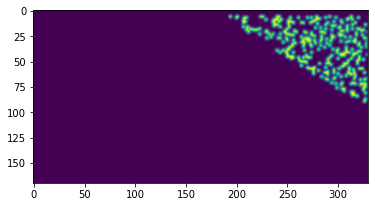

387 2571 [ 6. 11.]
194.4000000000001 341.0 6.099999999999909 97.09999999999991


In [159]:
# fastq_image = generate_img(y_coord,x_coord, 0, 0, max_y, max_x, 1, True, 1)
# image_array_FQ1 = np.asarray(fastq_image)
# idx = [i for i,x in enumerate(x_coord) if x_coord[i] >= X_c and (x_coord[i] <= X_c+330) and (y_coord[i] >= Y_c) and (y_coord[i] <= Y_c+170)]
# x_FQ = [x_coord[i] for i in idx]
# y_FQ = [y_coord[i] for i in idx]
# x_FQ = np.subtract(x_FQ,X_c-shift[1])
# y_FQ = np.subtract(y_FQ,Y_c-shift[0])
# fastq_image1 = generate_img(y_FQ,x_FQ, 0, 0, 170, 330, 1, True, 1)
# # image_array_FQ_t = image_array_FQ1[ Y_c:Y_c+170, X_c:X_c+330]
# # fig, ax = plt.subplots()
# # ax.imshow(image_array_FQ_t)
# # plt.show()
# fig, ax = plt.subplots()
# ax.imshow(fastq_image1)
# plt.show()
# print(X_c,Y_c, shift)
# print(min(x_FQ),max(x_FQ), min(y_FQ), max(y_FQ))

In [155]:
print(min(y_coord))

25.09999999999991


In [137]:
x = np.asarray(CM)[:,0]
y = np.asarray(CM)[:,1]
print(np.max(x)- np.min(x))
print(np.max(y)- np.min(y))

500.86880427532543
243.22028694461616


In [64]:
# Extracting traces

for i, pos in enumerate(good_pos):
    # Reading the smFRET movie
    img_smFRET = io.imread(os.path.join(path_smFRET,pos+'.tiff'))
    seq_matched = matched_sequences[i]
    centers_red = matched_centers_red[i]
    centers_green = matched_centers_green[i]
    n_traces = len(centers_red)
    [h,w] = [256,512]
    n_frames = img_smFRET.shape[0]

    weights_red = np.zeros([n_traces,2*r+1,2*r+1])
    weights_green = np.zeros([n_traces,2*r+1,2*r+1])
    traces_red =  np.zeros([n_traces,n_frames])
    traces_green = np.zeros([n_traces,n_frames])
    # Extracting the traces from matched smFRET peaks
    # Extracting the traces from matched smFRET peaks
    # Select matching peaks from peak_locations and their sequences


    for j,coord in enumerate(centers_red):
        x, y = coord
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_red[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            xt,yt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

        x, y = centers_green[j]
        x0 = int(x-r)
        x1 = int(x+r+1)
        y0 = int(y-r)
        y1 = int(y+r+1)
        dx = x-x0
        dy = y-y0

        it = np.nditer(weights_green[j], flags=['multi_index'], op_flags=['readwrite'])
        for w1 in it:
            xt,yt = it.multi_index
            w1[...] = 2*exp(-0.4*((xt-dx)**2+(yt-dy)**2))
        it.close()

    for i in range(n_frames):
        if i%100 == 0: print("Working on frame "+str(i))
        red1 = img_smFRET[i,256:,:]
        red1 = red1 - si.restoration.rolling_ball(red1, radius=rb_rad)
        green1 = img_smFRET[i,:256,:]
        green1 = green1 - si.restoration.rolling_ball(green1, radius=rb_rad)

        for j,coord in enumerate(centers_red):
            x, y = coord
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
            red2 = red1[x0:x1,y0:y1]
            traces_red[j,i] = np.sum(np.multiply(weights_red[j],red2))

            x, y = centers_green[j]
            x0 = int(x-r)
            x1 = int(x+r+1)
            y0 = int(y-r)
            y1 = int(y+r+1)
            dx = x-x0
            dy = y-y0
            green2 = green1[x0:x1,y0:y1]
            traces_green[j,i] = np.sum(np.multiply(weights_green[j],green2))


    # Save traces and sequences
    frame_rate = 5
    mdict = {
        "time": np.divide(range(n_frames),frame_rate),
        "Cy3": traces_red,
        "Cy5": traces_green,
        "Seq": seq_matched
    }

    savemat(os.path.join(current_direct, pos + "_traces.mat"), mdict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436


346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
12

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441


352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
12

18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
28

198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447


357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
13

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292


202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451


362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
13

32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298


208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457


367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
14

IndexError: list index out of range

# Main pipeline ends here

In [113]:
blob = blob_dog(
            np.asarray(img_beads_F), min_sigma=1, max_sigma=10, threshold=0.01
        )
print(blob)
print(np.asarray(img_beads_F).shape)

[[ 40.    5.    1.6]
 [ 28.   66.    1. ]
 [ 32.  190.    1. ]
 [151.  433.    1. ]
 [166.  410.    1. ]]
(256, 512)


In [138]:
# x_FQ = np.subtract(x_FQ,X_c-shift[1])
# y_FQ = np.subtract(y_FQ,Y_c-shift[0])
print(np.max(x_FQ)-np.min(x_FQ))
print(np.max(y_FQ)-np.min(y_FQ))


329.9000000000001
170.0


In [ ]:

    root = tk.Tk()
    root.attributes("-topmost", True)
    root.withdraw()
    labels_res = []
    posX_res = []
    posY_res = []
    file_path = fd.askopenfilename(title = "Choose the position list", initialdir = "D:/Experiments/MUSCLE DONUTS/20220824_FC_Nano_Cas9_CCR5/parameter")
    pos_file = open(file_path)
    data = json.load(pos_file)
    POS = data['POSITIONS']

    labels = [P['LABEL'] for P in POS]
    posX = [P['DEVICES'][0]['X'] for P in POS]
    posY = [P['DEVICES'][0]['Y'] for P in POS]
    
    for i,x in enumerate(labels):
        x = int(2329 + (posX[i] - 28522.9)/0.34)
        y = int(2042 - (posY[i] + 1313.3)/0.34)
        if (x > 0 ) and (y > 0):
            if (y+y_border<2866) and (x+x_border < 2944) :
                labels_res.append (labels[i])
                posX_res.append (posX[i])
                posY_res.append( posY[i])
    
    
    X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos279']
    Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos279']
    #X_c, Y_c = scaling_seq(X_c[0], Y_c[0])

In [ ]:
print(len(labels_res))
print(len(labels_out))
print(len(labels))
labels_out = []
for el in labels: 
    if el not in labels_res:
        labels_out.append(el)

In [ ]:
min_X_c = min(posX)
max_Y_c = max (posY)

print (min_X_c, max_Y_c)
for i,el in enumerate(labels): 
    if (posX[i] == min_X_c) and (posY[i] == max_Y_c):
        Pos_init = el

In [ ]:
new_X_c = min_X_c + 0.34*2392
new_Y_c = max_Y_c - 0.34*754 
print(new_X_c, new_Y_c)
print(sorted(posY))

In [ ]:
for i,el in enumerate(labels): 
    if (posX[i] == 27202.9) and (posY[i] == -1133.3):
        print (el)

In [ ]:
app_dir = "C:/Users/panf/Documents/Muscle_intermediates/test_folder_4/"
for pos in labels_res :
    for current_dir,dirs, files in os.walk(app_dir) :
        for el in files: 
            print(el.split('.')[-2])
            print(pos)
            if el.split('.')[-2] == pos:
                img1 = io.imread(current_dir + '/' + el) #reading the stack of images
                
                img1 = img1.astype("ushort") #turn from float format to ushort
                img1 = img1 [256:512, 0:512]
                plt.figure()
                plt.imshow(img1)


In [ ]:
X_c = [posX[i] for i,x in enumerate(labels) if labels[i]=='Pos148']
Y_c = [posY[i] for i,x in enumerate(labels) if labels[i]=='Pos148']

x_c, y_c = scaling_seq (X_c[0], Y_c[0])
print (x_c, y_c)

In [ ]:
phase_cross_correlation

In [ ]:
import math
seq_coord = np.empty([0,2], dtype=int)
fret_coord = np.empty([0,2], dtype=int)
current_direct = "D:/nanobio/uppsala/muscle/Muscle_Misha/beads/"
for current_dir,dirs, files in os.walk(current_direct) :
        for el in files: 
            coord = np.load(current_dir + '/' + el) 
            length = len(coord)
            fret_coord = np.concatenate ((fret_coord, coord[0:int(length/2)] ), axis = 0 )
            seq_coord = np.concatenate ((seq_coord, coord[int(length/2):length] ), axis = 0 )

seq_coord = seq_coord * 1.7
#print(seq_coord)
#print(fret_coord)
distance1 = []
length = len(seq_coord)
print (length)
res = np.concatenate ((seq_coord, fret_coord), axis = 1)
for i in range(length):
    
    distance1.append(math.sqrt(math.pow((seq_coord[i][0] - fret_coord[i][0]),2) + math.pow((seq_coord[i][1] - fret_coord[i][1]),2)))
    print(math.sqrt(math.pow((seq_coord[i][0] - fret_coord[i][0]),2) + math.pow((seq_coord[i][1] - fret_coord[i][1]),2)))


In [ ]:
for row in fret_coord:
    print(row[1])

In [8]:
print (x_coord[100:300])


seq_touple = (x_coord, y_coord, sequence)
print(seq_touple[2][0])
print(data['sequence'])
with open('data.txt', 'w') as outfile:
    json.dump(data['sequence'], outfile)

[2742.  2741.9 2741.9 2741.8 2741.8 2741.7 2741.7 2741.6 2741.6 2741.5
 2741.5 2741.4 2741.3 2741.3 2741.2 2741.1 2741.1 2741.  2741.  2741.
 2741.  2740.9 2740.9 2740.9 2740.9 2740.8 2740.8 2740.7 2740.7 2740.6
 2740.4 2740.4 2740.4 2740.3 2740.3 2740.3 2740.2 2740.2 2740.2 2740.1
 2740.  2740.  2739.8 2739.8 2739.8 2739.7 2739.6 2739.4 2739.4 2739.3
 2739.3 2739.1 2739.  2738.9 2738.8 2738.8 2738.8 2738.7 2738.5 2738.5
 2738.5 2738.4 2738.4 2738.3 2738.3 2738.3 2738.2 2738.2 2738.2 2738.2
 2738.1 2738.1 2738.  2738.  2738.  2737.9 2737.9 2737.9 2737.9 2737.8
 2737.8 2737.6 2737.5 2737.4 2737.3 2737.2 2737.2 2737.2 2737.  2737.
 2736.9 2736.7 2736.7 2736.6 2736.6 2736.6 2736.5 2736.4 2736.4 2736.4
 2736.3 2736.3 2736.1 2736.  2736.  2736.  2735.9 2735.9 2735.9 2735.9
 2735.7 2735.7 2735.6 2735.6 2735.5 2735.5 2735.4 2735.3 2735.3 2735.2
 2735.1 2735.  2734.9 2734.8 2734.8 2734.8 2734.8 2734.7 2734.7 2734.6
 2734.6 2734.6 2734.5 2734.4 2734.4 2734.3 2734.3 2734.3 2734.2 2734.1
 2734.1 